In [1]:
###############################################################################
# OPTIMIZATION & AI - LAB 05 FERHAT MATTHIEU ET LOVITON PIERRE
###############################################################################

In [1]:
# System imports
from time import process_time

#Extra library imports
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from sklearn.cluster import KMeans
from scipy import sparse
from skimage.morphology import skeletonize
#from sknetwork.path import shortest_path
from scipy.sparse.csgraph import shortest_path

In [2]:
# User inputs
impath = 'isep.png'
end_point = [321, 66]
start_point = [47, 482]

Nowadays, many web or phone applications help you planning your itinerary considering real-time traffic conditions.  Among these applications, Google Maps proposes an interactive map created using satellite images and aerial photos. The user selects the desired starting and ending points, and the application then finds the shortest path according to the current traffic conditions, but also other parameters such as the mode of transport.
In this lab, we will try to reproduce a very basic version of Google Maps using famous shortest path algorithms. 

# I.  Journey planning on a Google Maps' image

## a) Data exploration and pre-processing

On this sunny spring morning, you rode your bike to attend the lecture course on optimization & AI planned at Paris. Unfortunately, the lab will take place at Issy-les-Moulineaux, 30 minutes after the end of the lecture... Will you be on time?

Let's look at the map given by a famous phone application to try to answer this question.

<font color='blue'> Question 1: load the map image. Display it, and plot also on this same figure the starting (in magenta) and ending (in red) points. You have to use the variables in the "user inputs" cell.  </font>

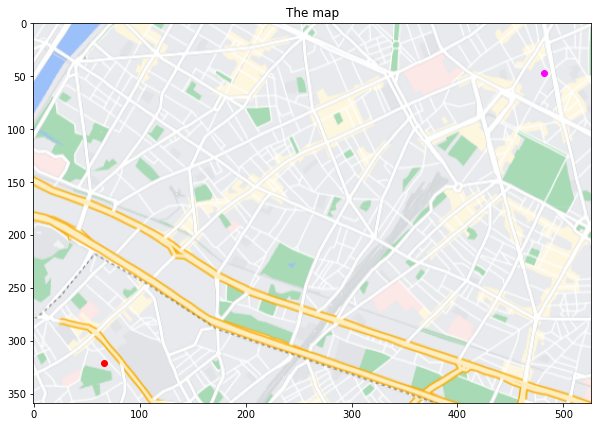

In [3]:
# Load the input image
im_arr = np.array(Image.open(impath))

# Get the size of the image
sx, sy, nb_channels = im_arr.shape

# Display the input map, the starting and ending points
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(im_arr)
ax.scatter(x=start_point[1],y=start_point[0], color = 'magenta')
ax.scatter(x = end_point[1], y = end_point[0], color = 'r')
plt.title('The map')
plt.show()

Fortunately, we see that there exists a path between the two locations! We will use some shortest path methods seen during lesson 6 to find the optimal bike journey. To that purpose, we have to create a **graph**, where **each node represents a pixel of the above image belonging to a road**. Thus, a candidate path is a sequence of **adjacent** pixels going from the starting point to the ending point.

To create this graph, we first need to create the binary image of all possible roads. Looking at the above image, we suppose that a road may be represented in yellow or white. 
To simplify the problem, we will work only on one of the channels of the image (red, green or blue). To select the most appropriate channel, we now look at each of them.

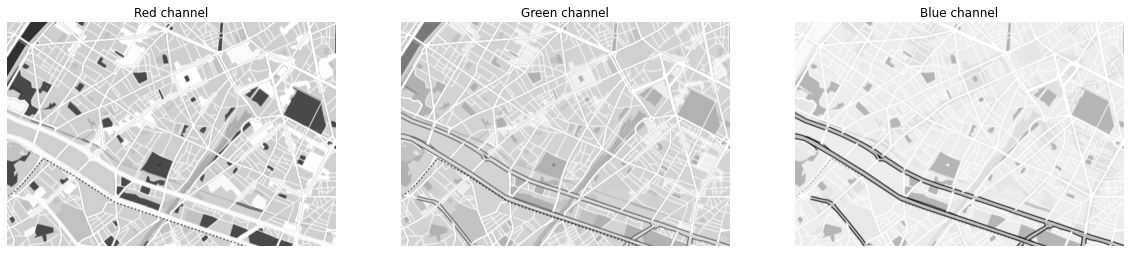

In [4]:
# Display the 3 channels
fig, ax = plt.subplots(1, 3, figsize=(20, 20))
for channel_id, color in zip(range(nb_channels),
                             ['Red', 'Green', 'Blue']):
    ax[channel_id].imshow(im_arr[:, :, channel_id],
                          cmap='gray')
    ax[channel_id].set_title(color + ' channel')
    ax[channel_id].axis('off')

You should see which channel is particularly appropriate!
We will now apply a classification algorithm on the pixels of this channel to create the binary image of the roads.

<font color='blue'> Question 2: put the most relevant channel into the "input_arr"  variable. Apply a K-Means on this channel using the associated Scikit-Learn function, setting the number of clusters to 3, and the "random_state" parameter to 0 so that your results and reproducible. Reshape the output classification into an image of same size as the input image. You may use the "reshape" function from Numpy.</font>

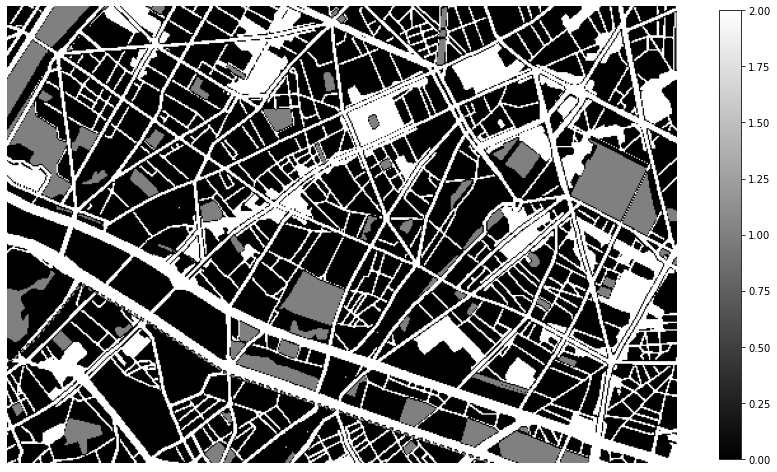

In [5]:
# Extract the most appropriate channel
input_arr = im_arr[:, :, 0]

# Reshape your channel image into a vector (needed to apply K-Means)
input_arr = input_arr.reshape((-1, 1)) 

# Apply a 3-class K-Means on the selected channel
kmeans = KMeans(n_clusters= 3, random_state=0).fit(input_arr)

# Select the vector of labels
seg_arr = kmeans.labels_

# Reshape this vector into an image of size sx x sy
seg_arr = seg_arr.reshape((sx, sy)) 

# Display the output classification
fig, ax = plt.subplots(figsize=(15, 15))
im0 = ax.imshow(seg_arr, cmap='gray', vmin=0, vmax=2) #
ax.axis('off')
cb = plt.colorbar(im0, shrink=0.55)
plt.show()

You see that the input image was segmented into three classes. You have now to extract the one corresponding to the roads.

<font color='blue'> Question 3: create the **binary image** of the roads extracting the appropriate class. </font>

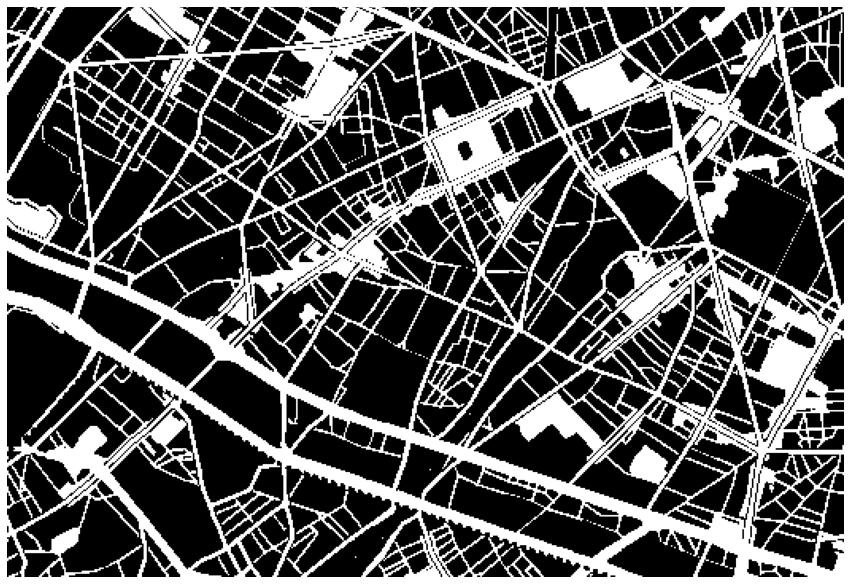

In [6]:
# Select the road array
road_arr = seg_arr
road_arr[road_arr==1]=0
road_arr[road_arr==2]=1


# Display the binary image of the roads
fig, ax = plt.subplots(figsize=(15, 15))
ax.imshow(road_arr, cmap='gray')
ax.axis('off')
plt.show()

That's quite good! To reduce the computation time, we can "shrink" the road. This step is not mandatory, but trully recommanded...
To that purpose, we now compute the morphological skeleton of the binary image of the road (if interested, you can find many information on this method on various web sites).

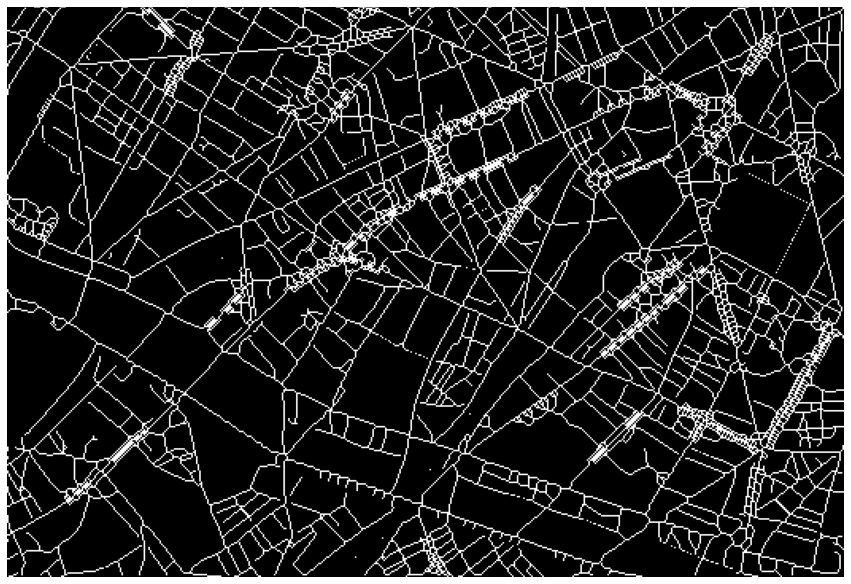

In [7]:
# Compute the morphological skeleton of the road map
road_arr = skeletonize(road_arr).astype(int)

# Display the post-processed binary image of the roads
fig, ax = plt.subplots(figsize=(15, 15))
ax.imshow(road_arr, cmap='gray')
ax.axis('off')
plt.show()

We are now ready to create the graph of this binary road map! But first, we need to check that our starting and ending points belong to this map.

In [8]:
# Display the road map values of the starting and ending points
print(road_arr[start_point[0], start_point[1]])
print(road_arr[end_point[0], end_point[1]])

0
0


Unfortunately, we did not precisely choose the starting and ending points. In fact, that is not a problem: we have to associate each of these two points with the closest one on the road map. This process is frequently performed for this kind of application!

<font color='blue'> Question 4: replace the starting point with the nearest pixel on the road, "nearest" meaning with the smallest euclidian distance. Do the same for the ending point. </font>

In [9]:
end_point = [321, 66]
start_point = [47, 482]

# Get the coordinates of the road pixels 
[x, y] = np.where(road_arr == 1)

# Replace the starting point with the nearest pixel on the road
start_loc = np.argmin(np.sqrt(np.square(start_point[0]-x) +  np.square(start_point[1]-y)))
start_point = (x[start_loc],y[start_loc])


# Replace the ending point with the nearest pixel on the road
end_loc = np.argmin(np.sqrt((end_point[0]-x)**2+(end_point[1]-y)**2))
end_point = (x[end_loc],y[end_loc])


# Check that the updated points are on the roads
print(road_arr[start_point[0], start_point[1]])
print(road_arr[end_point[0], end_point[1]])

1
1


Hopefully, it worked! We can now deal with the major pre-processing step: converting the road map into a graph.

As said previously, each node of the expected graph is a pixel of the road map. We will create the (unweighted) adjacency matrix $A$, such as $A[i, j] = 1$ if pixels $i$ and $j$ are adjacent, 0 otherwise. We have to define more precisely what "adjacent" means: we decide that two pixels are adjacent if the euclidian distance between them is equal or less than $\sqrt{2}$ pixels. Thus, they have to touch each other on the same line, column or diagonal. To reduce computation time, the $A$ matrix should be of size nb_pixels x nb_pixels, with **nb_pixels the number of road pixels**.

<font color='blue'> Question 5: create the adjacency matrix using the "sparse.csr_matrix" function from Scipy. **As usually,you have to look at the documentation of this function, and study the given examples to write the appropriate answer!**</font>

In [10]:
x[0]

0

In [11]:
adja_matrix = np.zeros((len(x),len(x)))

In [12]:
# Number of input pixels/nodes
nb_pixels = len(x)

# Create the adjacency matrix
for i in range (nb_pixels):
    dist = np.sqrt(np.square(x[i]-x) +  np.square(y[i]-y))
    idx = np.where(dist<=np.sqrt(2))
    for j in range(len(idx)):
        adja_matrix[idx[j],i] = 1

In [13]:
adja_matrix

array([[1., 1., 0., ..., 0., 0., 0.],
       [1., 1., 1., ..., 0., 0., 0.],
       [0., 1., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 1., 0.],
       [0., 0., 0., ..., 1., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.]])

In [14]:
adja_matrix.shape

(22575, 22575)

We have now everything we need to apply a shortest path method on the created graph to solve our problem!

## b) Shortest path algorithms

<font color='blue'> Question 6: apply the **Dijkstra's algorithm** on the **unweighted** adjacency matrix of the input graph to find the shortest path between the selected starting and ending points. You have to use the "shortest path" function from Scikit-network **or** Scipy. What is the length of the resulting path? </font>

In [18]:
from scipy.sparse import csr_matrix

In [38]:
dist_matrix, predecessors = shortest_path(csgraph = csr_matrix(adja_matrix), method = 'D', directed = True,indices=start_loc, unweighted=True, return_predecessors=True)


In [20]:
dist_matrix[end_loc]

473.0

To compute the transport time, we need the cost between two adjacent edges of the shortest path to be proportional to the euclidian distance between the two associated pixels. We just relaunch our algorithm taking the **weighted** adjacency matrix as an input, so that $A[i, j] = d(i, j)$, with $d(i, j)$ the euclidian distance between two **adjacent** pixels $i$ and $j$. We still have $A[i, j] = 0$ if pixels $i$ and $j$ are not adjacent.

<font color='blue'> Question 7: apply the **Dijkstra's algorithm** on the **weighted** adjacency matrix of the input graph to find the shortest path between the selected starting and ending points. You have to use the "shortest path" function from Scikit-network **or** Scipy. What is the length of the resulting path? </font>

In [78]:
adja_matrix_w = np.zeros((len(x),len(x)))
for i in range (nb_pixels):
    dist_w = np.sqrt(np.square(x[i]-x) +  np.square(y[i]-y))
    idx_w = np.where(dist_w<=np.sqrt(2))
    for j in range(len(idx_w)):
        adja_matrix_w[idx_w[j],i] = dist_w[idx_w[j]]

In [39]:
dist_matrix_w, predecessors_w = shortest_path(csgraph = csr_matrix(adja_matrix_w), method = 'D', directed = True,indices=start_loc,unweighted=False, return_predecessors=True)


In [23]:
dist_matrix_w[end_loc]

592.4650788387078

We obtained two different lengths. We can also visually check that we found two different paths.

<font color='blue'> Question 8: display the RGB input image, and plot also on this same figure the starting (in magenta) and ending (in red) points, the paths obtained in question 7 (in cyan) and 8 (in blue).  </font>

In [67]:
list = [end_loc]

for i in range(len(predecessors)):
    if predecessors[-1-i]!=start_loc:
        list.append(predecessors[-1-i])
    else:
        break

    
                
        

In [71]:
path1 = (x[list],y[list])

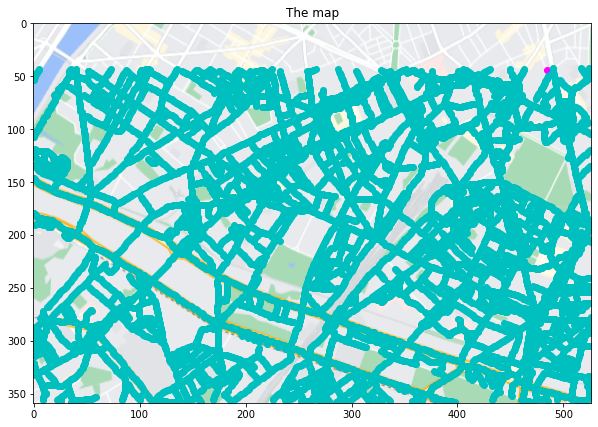

In [74]:
# Display the RDG input map, the starting and ending points, and paths
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(im_arr)
ax.scatter(x=start_point[1],y=start_point[0], color = 'magenta')
ax.scatter(x = end_point[1], y = end_point[0], color = 'r')
ax.scatter(x = path1[1],y=path1[0], color = 'c')
#ax.plot(dist_matrix_w, color = 'b')
plt.title('The map')
plt.show()

Before concluding, we can verify that we choose the most relevant method to find the shortest path.
We will compare with the Bellman-Ford algorithm we also saw during the course.

<font color='blue'> Question 9: apply the **Bellman-Ford algorithm** on the **weighted** adjacency matrix of the input graph to find the shortest path between the selected starting and ending points. You have to use the "shortest path" function from Scikit-network **or** Scipy. What algorithm would you prefer for our application? </font>

In [51]:
dist_matrix_bf, predecessors_bf = shortest_path(csgraph = csr_matrix(adja_matrix_w), method = 'BF', directed = True,indices=start_loc, unweighted=False, return_predecessors=True)


In [52]:
dist_matrix_bf[end_loc]

592.4650788387078

<font color='blue'> 
    This algorithm can be used when weights are negative. Here we don't have negative weights so it's not essential.</font>

Finally, we can answer the big question: will we be late at the next lab session riding our bike?

<font color='blue'> Question 10: supposing the distance between two **adjacent pixels** is proportional to 8102 mm ($d(i, j)=8102$ mm if $i$ and $j$ are on the same line/column, $d(i, j)=8102\sqrt{2}$ mm otherwise), will you be on time for your next lab session starting in 30 minutes, driving continuously at 13 km/h? </font>

In [ ]:
### ...to complete... ###

<font color='blue'> To complete</font>